                            OLS Regression Results                            
Dep. Variable:                   Rape   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     16.39
Date:                Sun, 10 May 2020   Prob (F-statistic):           2.21e-07
Time:                        12:52:27   Log-Likelihood:                -164.13
No. Observations:                  50   AIC:                             336.3
Df Residuals:                      46   BIC:                             343.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4741      4.696     -0.527      0.6

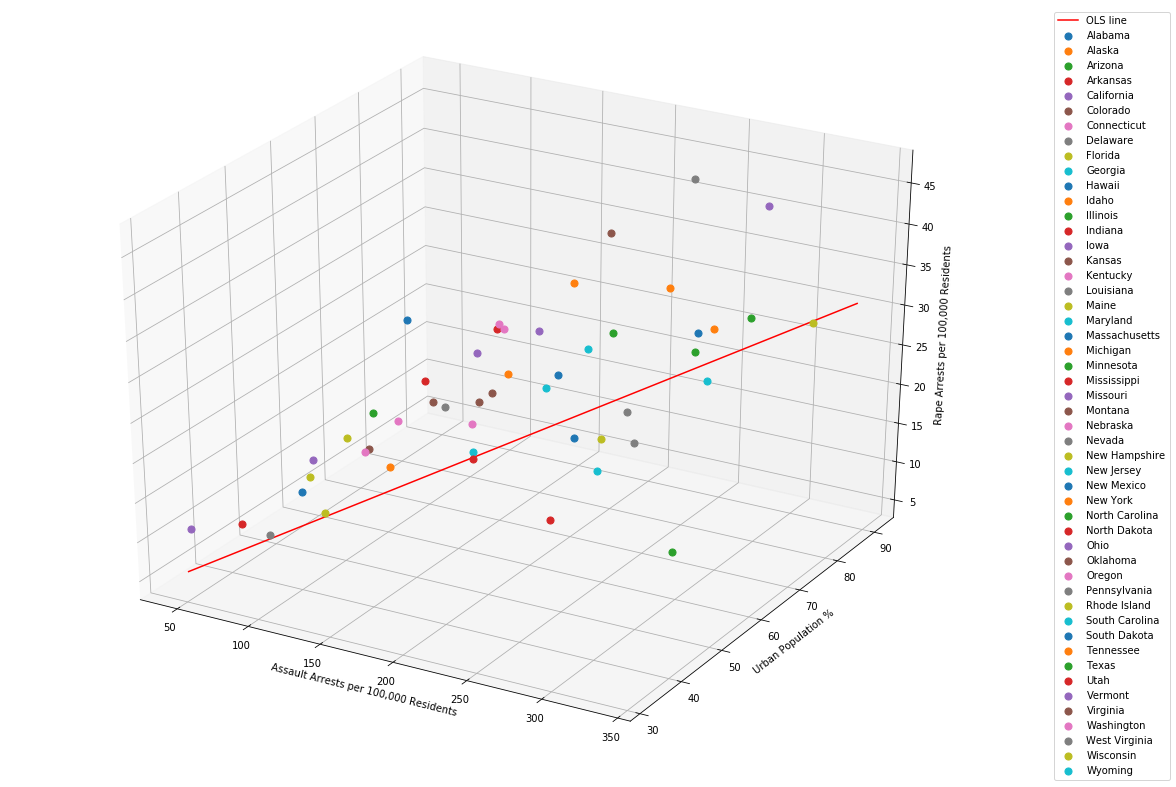

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# importing and subsetting the data

# data obtained from 'https://forge.scilab.org/index.php/p/rdataset/source/tree/master/csv/datasets/USArrests.csv'

# documentation for data: 'https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests'

dframe = pd.read_csv('USArrests.csv')

dframe.rename(columns = {'Unnamed: 0':'State'}, inplace = True) 


y = dframe['Rape']

x = dframe[['Assault', 'UrbanPop', 'Murder']]

x = sm.add_constant(x) 

mod = sm.OLS(y, x).fit()

print_mod = mod.summary()
print(print_mod)

# calculating a regression line

b0 = mod.params[0]
b1 = mod.params[1]
b2 = mod.params[2]
x1_assault = np.linspace(min(dframe['Assault']), max(dframe['Assault']))
x2_urbpop= np.linspace(min(dframe['UrbanPop']), max(dframe['UrbanPop']))
y_hat = b0 + b1*x1_assault + b2*x2_urbpop

# plotting the data and the regression line

fig = plt.figure(3,figsize = (18,14))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(dframe)):
    ax.scatter(dframe['Assault'][i], dframe['UrbanPop'][i], dframe['Rape'][i],  label = dframe['State'][i], s =50)
ax.plot(x1_assault, x2_urbpop, y_hat, color = 'red', label = 'OLS line')
plt.xlabel('Assault Arrests per 100,000 Residents')
plt.ylabel('Urban Population %')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
ax.set_zlabel('Rape Arrests per 100,000 Residents')
plt.show()
